# Platform Engagement and Growth Analytics

## Data Setup

In [46]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")
sns.set_palette("muted")

con=duckdb.connect()

con.execute("""
CREATE TABLE users_raw AS SELECT * FROM read_csv_auto('data/users.csv');
CREATE TABLE sessions_raw AS SELECT * FROM read_csv_auto('data/sessions.csv');
CREATE TABLE title_raw AS SELECT * FROM read_csv_auto('data/titles.csv');
""")

In [47]:
print("\nSample data from each table:")
print("================================")
print("Users Table:")
print(f"\n{con.execute("SELECT * FROM users_raw LIMIT 5").fetchdf()}")
print("================================")
print("Sessions Table:")
print(f"\n{con.execute("SELECT * FROM sessions_raw LIMIT 5").fetchdf()}")
print("Sessions Table:")
print(f"\n{con.execute("SELECT * FROM title_raw LIMIT 5").fetchdf()}")


Sample data from each table:
Users Table:

  user_id signup_date cancel_date region plan_type
0  U00001  2020-06-20         NaT     ES   Premium
1  U00002  2020-05-27  2020-11-19     UK     Basic
2  U00003  2021-02-21         NaT     ES  Standard
3  U00004  2020-07-02         NaT     KR   Premium
4  U00005  2023-08-14         NaT     UK     Basic
Sessions Table:

  session_id user_id       date device  duration title_id
0    S000001  U00661 2025-01-19     pc       8.0    T0061
1    S000002  U00192 2022-02-12  phone      22.0    T0117
2    S000003  U00911 2025-09-24     tv      52.0    T0145
3    S000004  U00747 2024-07-08  phone      17.0    T0025
4    S000005  U00651 2022-02-06  phone      81.0    T0048
Sessions Table:

  title_id country_of_origin  runtime        genre content_type
0    T0001                US       45    Animation      TV Show
1    T0002                BR      154  Documentary        Movie
2    T0003                JP       50      Romance      TV Show
3    T0004  

## Data Cleaning

### User Table

#### Checking for issues

In [48]:
print(con.execute("SELECT * FROM users_raw").fetchdf().info())
print(con.execute("SELECT * FROM users_raw LIMIT 5").fetchdf())


print("region values:")
print(con.execute("SELECT region, COUNT(region) FROM users_raw GROUP BY region").fetchdf())

print("plan_type values:")
print(con.execute("SELECT plan_type, COUNT(plan_type) FROM users_raw GROUP BY plan_type").fetchdf())

print("Date Values")
print(con.execute("""
SELECT 
    signup_date,
    cancel_date,
FROM users_raw;
""").fetchdf().describe())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(region IS NULL) AS null_region,
       COUNTIF(plan_type IS NULL) AS null_plan_type,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(signup_date IS NULL) AS null_signup_date,
       COUNTIF(cancel_date IS NULL) AS null_cancel_date
FROM users_raw;
""").fetchdf())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      1013 non-null   object        
 1   signup_date  1013 non-null   datetime64[us]
 2   cancel_date  572 non-null    datetime64[us]
 3   region       990 non-null    object        
 4   plan_type    999 non-null    object        
dtypes: datetime64[us](2), object(3)
memory usage: 39.7+ KB
None
  user_id signup_date cancel_date region plan_type
0  U00001  2020-06-20         NaT     ES   Premium
1  U00002  2020-05-27  2020-11-19     UK     Basic
2  U00003  2021-02-21         NaT     ES  Standard
3  U00004  2020-07-02         NaT     KR   Premium
4  U00005  2023-08-14         NaT     UK     Basic
region values:
   region  count(region)
0      NL             52
1      SE             58
2      IN             64
3      US             65
4      UK             75
5      KR      

#### Clean and validate, export to pandas dataframe

In [49]:
con.execute("""
CREATE OR REPLACE TABLE users_clean AS
WITH ranked AS (
  SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY signup_date DESC, cancel_date NULLS LAST) AS rn
  FROM users_raw
)
SELECT
  user_id,
  CAST(signup_date AS DATE) AS signup_date,
  CASE 
    WHEN TRY_CAST(cancel_date AS DATE) IS NULL THEN NULL
    WHEN TRY_CAST(cancel_date AS DATE) < TRY_CAST(signup_date AS DATE) THEN NULL  -- fix bad ordering
    ELSE CAST(cancel_date AS DATE)
  END AS cancel_date,
  CASE
    WHEN region IN ('US', 'CA', 'MX') THEN 'North America'
    WHEN region IN ('GB', 'FR', 'DE', 'IT', 'ES', 'NL', 'SE', 'NO', 'DK', 'FI') THEN 'Europe'
    WHEN region IN ('AU', 'NZ') THEN 'Oceania'
    WHEN region IN ('IN', 'CN', 'JP', 'KR', 'SG') THEN 'Asia'
    WHEN region IN ('BR', 'AR', 'CL', 'CO') THEN 'South America'
    WHEN region IN ('ZA', 'NG', 'EG') THEN 'Africa'
    ELSE NULL
  END AS region,
  plan_type
FROM ranked
WHERE rn = 1
  AND user_id IS NOT NULL
;
""")

print("region values:")
print(con.execute("SELECT region, COUNT(region) FROM users_clean GROUP BY region").fetchdf())

print("plan_type values:")
print(con.execute("SELECT plan_type, COUNT(plan_type) FROM users_clean GROUP BY plan_type").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(region IS NULL) AS null_region,
       COUNTIF(plan_type IS NULL) AS null_plan_type,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(signup_date IS NULL) AS null_signup_date,
       COUNTIF(cancel_date IS NULL) AS null_cancel_date
FROM users_clean;
""").fetchdf())

users = con.execute("""SELECT * FROM users_clean""").fetch_df()

region values:
          region  count(region)
0         Europe            382
1           Asia            206
2           None              0
3  North America            201
4        Oceania             52
5  South America             65
plan_type values:
  plan_type  count(plan_type)
0  Standard               352
1     Basic               440
2   Premium               194
3      None                 0

Null Values:
   total_rows  null_region  null_plan_type  null_user_id  null_signup_date  \
0        1000         94.0            14.0           0.0               0.0   

   null_cancel_date  
0             434.0  


#### Looking for outliers

  user_id signup_date cancel_date         region plan_type
0  U00047  2024-03-02  2024-03-19         Europe   Premium
1  U00058  2020-11-02         NaT           Asia  Standard
2  U00068  2024-04-12  2024-05-15           Asia     Basic
3  U00080  2021-05-12  2023-01-07  North America     Basic
4  U00099  2022-03-21  2023-06-07        Oceania     Basic


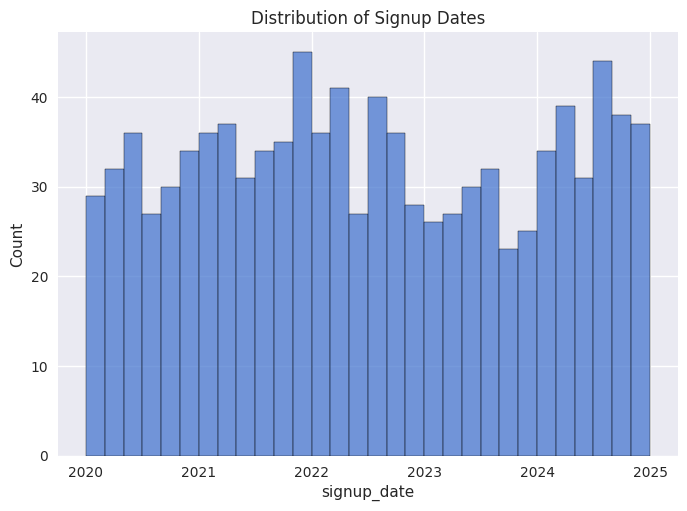

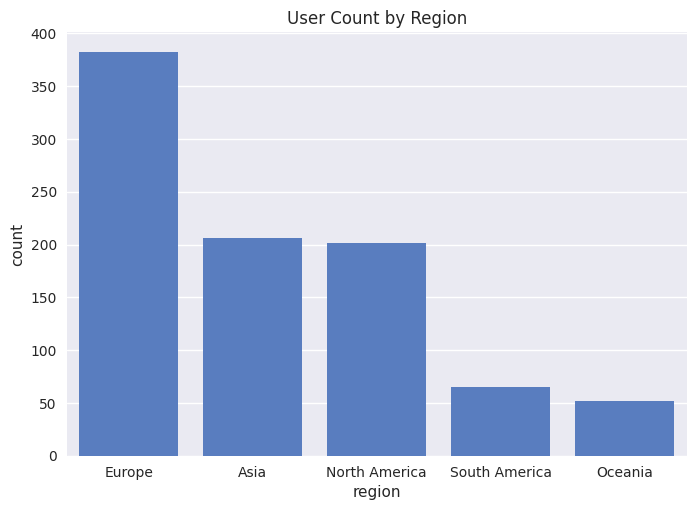

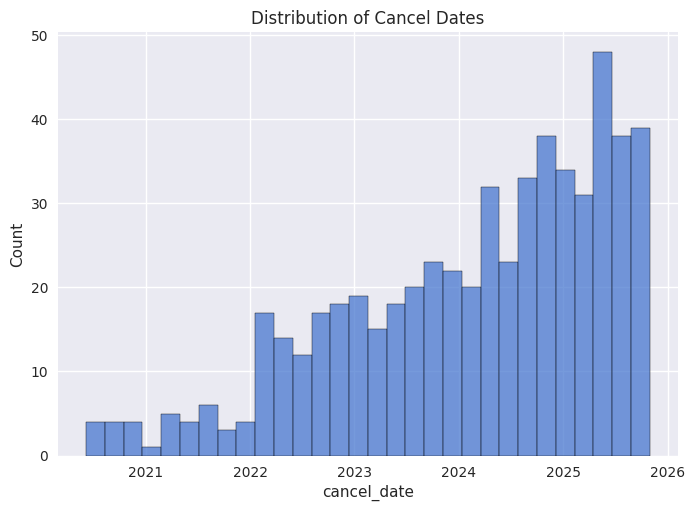

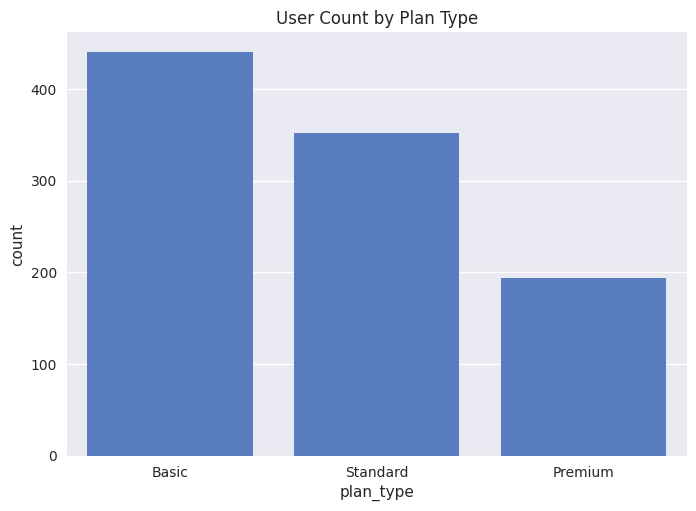

In [50]:
print(users.head())

sns.histplot(users, x='signup_date', bins=30)
plt.title('Distribution of Signup Dates')
plt.show()

sns.countplot(data=users, x='region', order=users['region'].value_counts().index)
plt.title('User Count by Region')
plt.show()

sns.histplot(users, x='cancel_date', bins=30)
plt.title('Distribution of Cancel Dates')
plt.show()

sns.countplot(data=users, x='plan_type', order=users['plan_type'].value_counts().index)
plt.title('User Count by Plan Type')
plt.show()

### Sessions Table

#### Description

In [51]:
print(con.execute("SELECT * FROM sessions_raw").fetchdf().info())

print("\nSample values:")
print(con.execute("SELECT * FROM sessions_raw LIMIT 5").fetchdf())

print("\nSession Quantitative Data Statistics:")
print(con.execute("SELECT date, duration FROM sessions_raw").fetchdf().describe())

print("\nSession ID Distinct Count:")
print(con.execute("""
SELECT COUNT(DISTINCT session_id) AS distinct_session_ids,
       COUNT(session_id) AS total_session_ids
FROM sessions_raw;
""").fetchdf())

print("\nDevice values:")
print(con.execute("SELECT device, COUNT(device) from sessions_raw GROUP BY device").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(duration IS NULL) AS null_duration,
       COUNTIF(device IS NULL) AS null_device,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(date IS NULL) AS null_date
FROM sessions_raw;
""").fetchdf())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   session_id  10000 non-null  object        
 1   user_id     10000 non-null  object        
 2   date        10000 non-null  datetime64[us]
 3   device      9752 non-null   object        
 4   duration    9980 non-null   float64       
 5   title_id    9970 non-null   object        
dtypes: datetime64[us](1), float64(1), object(4)
memory usage: 468.9+ KB
None

Sample values:
  session_id user_id       date device  duration title_id
0    S000001  U00661 2025-01-19     pc       8.0    T0061
1    S000002  U00192 2022-02-12  phone      22.0    T0117
2    S000003  U00911 2025-09-24     tv      52.0    T0145
3    S000004  U00747 2024-07-08  phone      17.0    T0025
4    S000005  U00651 2022-02-06  phone      81.0    T0048

Session Quantitative Data Statistics:
                            

#### Standardize Columns & Handle Nulls

In [52]:
con.execute("""
CREATE OR REPLACE TABLE sessions_clean AS
  SELECT
    session_id,
    CAST(date AS DATE) AS date,
    CASE 
      WHEN TRY_CAST(duration AS DOUBLE) IS NULL OR TRY_CAST(duration AS DOUBLE) < 0 THEN NULL
      ELSE TRY_CAST(duration AS DOUBLE)
    END AS duration,
    device,
    user_id,
    title_id
  FROM sessions_raw
  WHERE session_id IS NOT NULL AND duration < 300 AND duration > 0 AND user_id IS NOT NULL AND title_id IS NOT NULL AND date IS NOT NULL
""")

print(con.execute("SELECT * FROM sessions_clean").fetchdf().info())

print("\nSample values:")
print(con.execute("SELECT * FROM sessions_clean LIMIT 5").fetchdf())

print("\nSession Quantitative Data Statistics:")
print(con.execute("SELECT date, duration FROM sessions_clean").fetchdf().describe())

print("\nSession ID Distinct Count:")
print(con.execute("""
SELECT COUNT(DISTINCT session_id) AS distinct_session_ids,
       COUNT(session_id) AS total_session_ids
FROM sessions_clean;
""").fetchdf())

print("\nDevice values:")
print(con.execute("SELECT device, COUNT(device) from sessions_clean GROUP BY device").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(duration IS NULL) AS null_duration,
       COUNTIF(device IS NULL) AS null_device,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(date IS NULL) AS null_date,
      COUNTIF(title_id IS NULL) AS null_title_id
FROM sessions_clean;
""").fetchdf())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9938 entries, 0 to 9937
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   session_id  9938 non-null   object        
 1   date        9938 non-null   datetime64[us]
 2   duration    9938 non-null   float64       
 3   device      9692 non-null   object        
 4   user_id     9938 non-null   object        
 5   title_id    9938 non-null   object        
dtypes: datetime64[us](1), float64(1), object(4)
memory usage: 466.0+ KB
None

Sample values:
  session_id       date  duration device user_id title_id
0    S000001 2025-01-19       8.0     pc  U00661    T0061
1    S000002 2022-02-12      22.0  phone  U00192    T0117
2    S000003 2025-09-24      52.0     tv  U00911    T0145
3    S000004 2024-07-08      17.0  phone  U00747    T0025
4    S000005 2022-02-06      81.0  phone  U00651    T0048

Session Quantitative Data Statistics:
                             

#### Dedup

In [53]:
print("\nRemaining Duplicate Rows:")
print(con.execute("""
WITH duplicate_sessions AS (
SELECT session_id
FROM sessions_clean
GROUP BY session_id
HAVING COUNT(*) > 1
)
SELECT
                  date,
                  duration,
                  device,
                  title_id
FROM sessions_clean
WHERE session_id IN (SELECT session_id FROM duplicate_sessions)
ORDER BY session_id, user_id, date, duration, device, title_id NULLS LAST
""").fetchdf())

con.execute("""
CREATE OR REPLACE TABLE sessions_clean AS
WITH ranked AS (
SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY session_id ORDER BY user_id, date, duration, device, title_id NULLS LAST) AS rn
FROM sessions_clean
)
SELECT
    session_id,
    date,
    duration,
    device,
    user_id,
    title_id
FROM ranked
WHERE rn = 1 AND duration IS NOT NULL
""")

print("\nSession ID Distinct Count:")
print(con.execute("""
SELECT COUNT(DISTINCT session_id) AS distinct_session_ids,
       COUNT(session_id) AS total_session_ids
FROM sessions_clean;
""").fetchdf())

print("\nRemaining Duplicate Rows:")
print(con.execute("""
WITH duplicate_sessions AS (
SELECT session_id
FROM sessions_clean
GROUP BY session_id
HAVING COUNT(*) > 1
)
SELECT
                  date,
                  duration,
                  device,
                  title_id
FROM sessions_clean
WHERE session_id IN (SELECT session_id FROM duplicate_sessions)
ORDER BY session_id, user_id, date, duration, device, title_id NULLS LAST
""").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(duration IS NULL) AS null_duration,
       COUNTIF(device IS NULL) AS null_device,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(date IS NULL) AS null_date,
       COUNTIF(title_id IS NULL) AS null_title_id
FROM sessions_clean;
""").fetchdf())
print("\nSession Quantitative Data Statistics:")
print(con.execute("SELECT date, duration FROM sessions_clean").fetchdf().describe())
print("\nSample values:")
print(con.execute("SELECT * FROM sessions_clean").fetch_df().head())


Remaining Duplicate Rows:
          date  duration device title_id
0   2025-02-14      17.0  phone    T0031
1   2025-02-14      17.0  phone    T0031
2   2020-09-16      15.0  phone    T0128
3   2020-09-16      15.0  phone    T0128
4   2021-04-06       1.0     tv    T0030
..         ...       ...    ...      ...
193 2025-03-06      56.0     pc    T0097
194 2023-03-20      12.0     tv    T0195
195 2023-03-20      12.0     tv    T0195
196 2025-07-03       6.0  phone    T0083
197 2025-07-03       6.0  phone    T0083

[198 rows x 4 columns]

Session ID Distinct Count:
   distinct_session_ids  total_session_ids
0                  9839               9839

Remaining Duplicate Rows:
Empty DataFrame
Columns: [date, duration, device, title_id]
Index: []

Null Values:
   total_rows  null_duration  null_device  null_user_id  null_date  \
0        9839            0.0        243.0           0.0        0.0   

   null_title_id  
0            0.0  

Session Quantitative Data Statistics:
              

Export to Dataframe

In [54]:
sessions = con.execute("""SELECT * FROM sessions_clean""").fetch_df()
sessions.head()

,session_id,date,duration,device,user_id,title_id
0,S000001,2025-01-19,8.0,pc,U00661,T0061
1,S000049,2023-12-14,2.0,tv,U00297,T0011
2,S000066,2023-03-07,1.0,None,U00182,T0162
3,S000068,2022-01-31,19.0,phone,U00457,T0025
4,S000141,2023-09-15,1.0,phone,U00401,T0158


#### Finding Outliers

  session_id       date  duration device user_id title_id
0    S000001 2025-01-19       8.0     pc  U00661    T0061
1    S000049 2023-12-14       2.0     tv  U00297    T0011
2    S000066 2023-03-07       1.0   None  U00182    T0162
3    S000068 2022-01-31      19.0  phone  U00457    T0025
4    S000141 2023-09-15       1.0  phone  U00401    T0158


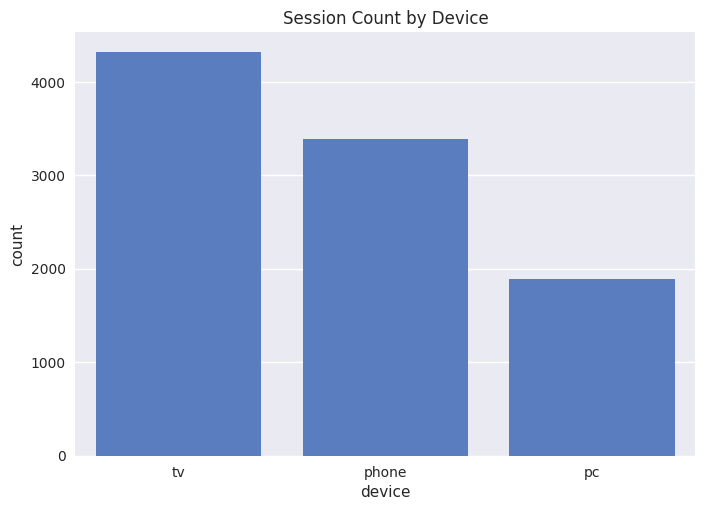

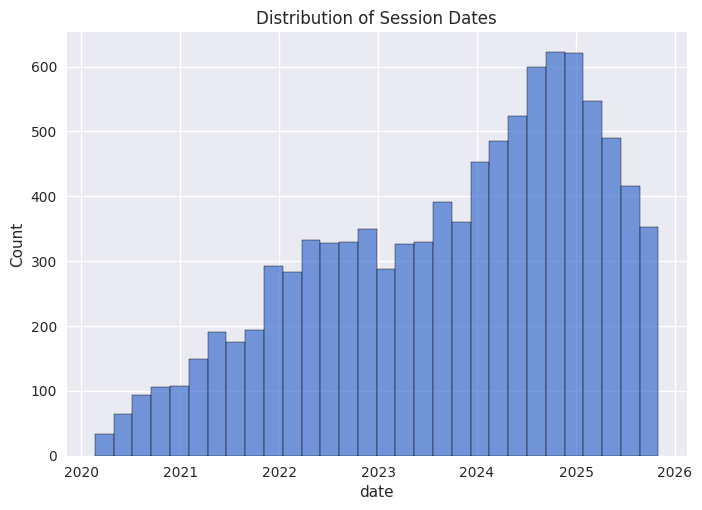

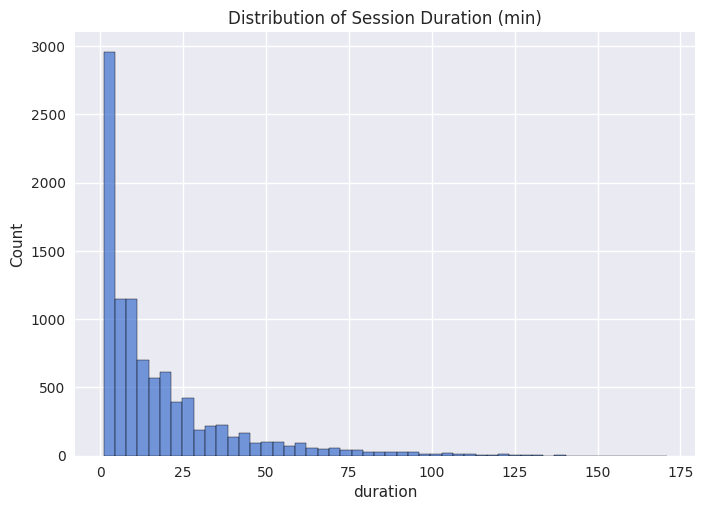

In [55]:
print(sessions.head())

sns.countplot(data=sessions, x='device', order=sessions['device'].value_counts().index)
plt.title('Session Count by Device')
plt.show()

sns.histplot(sessions, x='date', bins=30)
plt.title('Distribution of Session Dates')
plt.show()

sns.histplot(sessions, x='duration', bins=50)
plt.title('Distribution of Session Duration (min)')
plt.show()

### Content Table

#### Description


Sample values:
  title_id country_of_origin  runtime        genre content_type
0    T0001                US       45    Animation      TV Show
1    T0002                BR      154  Documentary        Movie
2    T0003                JP       50      Romance      TV Show
3    T0004                NL       25    Animation      TV Show
4    T0005                ES      120       Comedy        Movie

title Raw Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title_id           207 non-null    object
 1   country_of_origin  207 non-null    object
 2   runtime            207 non-null    int64 
 3   genre              204 non-null    object
 4   content_type       207 non-null    object
dtypes: int64(1), object(4)
memory usage: 8.2+ KB
None

Genre values:
          genre  count(genre)
0     Animation            24
1   Documentar

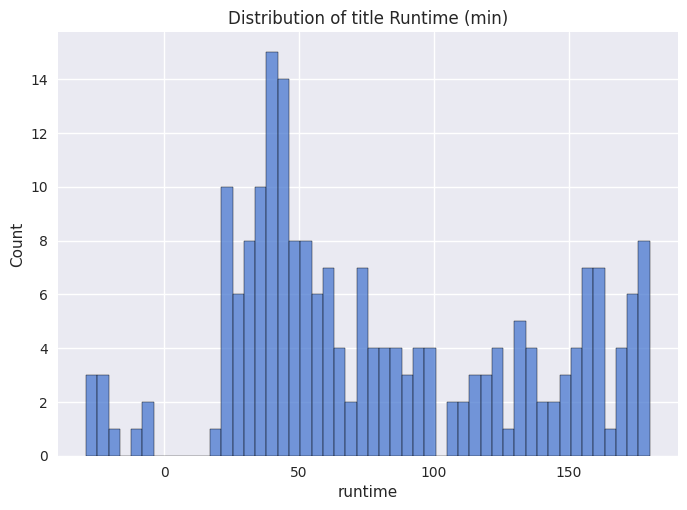

In [56]:
print("\nSample values:")
print(con.execute(""" SELECT * FROM title_raw LIMIT 5; """).fetch_df())

print("\ntitle Raw Table Info:")
print(con.execute("""SELECT * FROM title_raw""").fetch_df().info())

print ("\nGenre values:")
print(con.execute("SELECT genre, COUNT(genre) from title_raw GROUP BY genre").fetchdf())

print("\nDescriptive Statistics for Quantitative Columns:")
print(con.execute("SELECT runtime FROM title_raw").fetchdf().describe())

print("\nNull values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(genre IS NULL) AS null_genre,
       COUNTIF(runtime IS NULL) AS null_runtime,
       COUNTIF(title_id IS NULL) AS null_title_id
FROM title_raw;
""").fetchdf())

print("\nDuplicate Count:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT title_id) AS distinct_title_ids
FROM title_raw;
""").fetchdf())

sns.histplot(con.execute("SELECT runtime FROM title_raw").fetch_df(), x='runtime', bins=50)
plt.title('Distribution of title Runtime (min)')
plt.show()

#### Standardize Columns & Dedup

In [57]:
con.execute("""
CREATE OR REPLACE TABLE title_clean AS
  WITH ranked AS (
  SELECT
      *,
      ROW_NUMBER() OVER (PARTITION BY title_id ORDER BY genre, runtime NULLS LAST) AS rn
  FROM title_raw
  )
  SELECT
    title_id,
    genre,
    CASE
      WHEN TRY_CAST(runtime AS DOUBLE) IS NULL OR TRY_CAST(runtime AS DOUBLE) < 0 THEN NULL
      ELSE TRY_CAST(runtime AS DOUBLE)
    END AS runtime,
    content_type
  FROM ranked
  WHERE rn = 1 AND title_id IS NOT NULL AND runtime < 500 AND runtime > 0
""")

#### Visualize & Export to Dataframe


Sample values:
  title_id        genre  runtime content_type
0    T0009  Documentary    173.0        Movie
1    T0029      Romance     63.0        Movie
2    T0063       Comedy     21.0      TV Show
3    T0068       Sci-Fi    132.0        Movie
4    T0069       Horror     81.0        Movie

title Raw Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title_id      190 non-null    object 
 1   genre         187 non-null    object 
 2   runtime       190 non-null    float64
 3   content_type  190 non-null    object 
dtypes: float64(1), object(3)
memory usage: 6.1+ KB
None

Genre values:
          genre  count(genre)
0       Romance            20
1   Documentary            20
2        Comedy            19
3     Animation            21
4          None             0
5       Fantasy            18
6         Drama            13
7        Sc

   total_rows  distinct_title_ids
0         190                 190


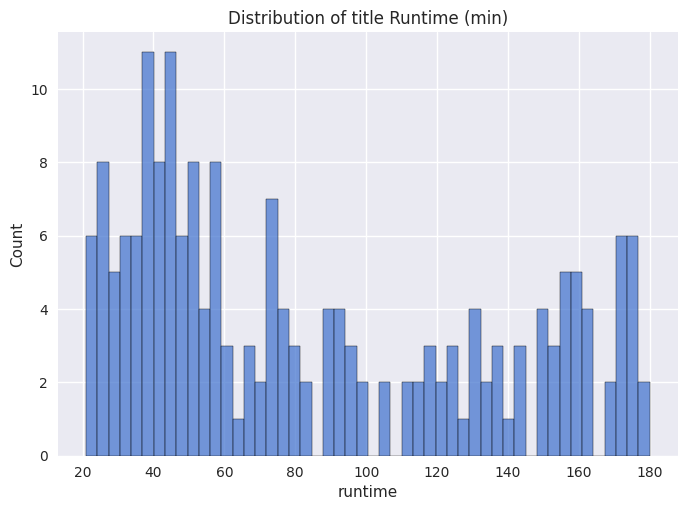

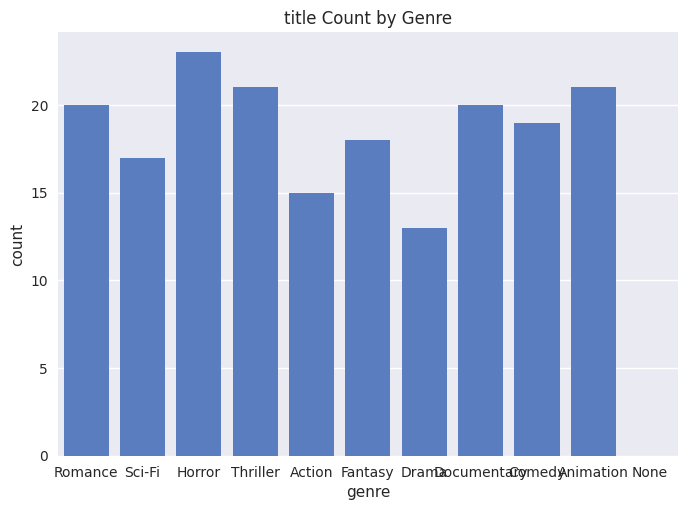

In [58]:
print("\nSample values:")
print(con.execute(""" SELECT * FROM title_clean LIMIT 5; """).fetch_df())

print("\ntitle Raw Table Info:")
print(con.execute("""SELECT * FROM title_clean""").fetch_df().info())

print ("\nGenre values:")
print(con.execute("SELECT genre, COUNT(genre) from title_clean GROUP BY genre").fetchdf())

print("\nDescriptive Statistics for Quantitative Columns:")
print(con.execute("SELECT runtime FROM title_clean").fetchdf().describe())

print("\nNull values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(genre IS NULL) AS null_genre,
       COUNTIF(runtime IS NULL) AS null_runtime,
       COUNTIF(title_id IS NULL) AS null_title_id
FROM title_clean;
""").fetchdf())

print("\nDuplicate Count:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT title_id) AS distinct_title_ids
FROM title_clean;
""").fetchdf())

sns.histplot(con.execute("SELECT runtime FROM title_clean").fetch_df(), x='runtime', bins=50)
plt.title('Distribution of title Runtime (min)')
plt.show()

sns.countplot(data=con.execute("SELECT * FROM title_clean").fetch_df(), x='genre', order=con.execute("SELECT genre, COUNT(genre) from title_clean GROUP BY genre").fetch_df()['genre'])
plt.title('title Count by Genre')
plt.show()

title = con.execute("""SELECT * FROM title_clean""").fetch_df()

### Augment

In [59]:
# Merge Data
df = sessions.merge(
    users,
    on='user_id',
    how='left',
    suffixes=('_session', '_user')
).merge(
    title,
    on='title_id',
    how='left',
    suffixes=('', '_title')
)
df = df.rename(columns={'duration': 'watch_duration', 'runtime' : 'title_runtime', 'device': 'session_device', 'title_type': 'session_title_type'})

df['days_before_signup'] = (df['signup_date'] - df['date']).dt.days
invalid = df[df['days_before_signup'] > 0]
invalid_sessions = df[df['date'] < df['signup_date']]
print(f"Invalid sessions: {len(invalid_sessions):,} ({len(invalid_sessions) / len(df):.2%} of total)")

# Remove invalid sessions
df = df[df['date'] >= df['signup_date']]
df = df[df['date'] < pd.to_datetime('2025-11-01')]
df.drop(columns=['days_before_signup'], inplace=True)

df.info()

Invalid sessions: 71 (0.72% of total)
<class 'pandas.core.frame.DataFrame'>
Index: 9766 entries, 0 to 9838
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   session_id      9766 non-null   object        
 1   date            9766 non-null   datetime64[us]
 2   watch_duration  9766 non-null   float64       
 3   session_device  9525 non-null   object        
 4   user_id         9766 non-null   object        
 5   title_id        9766 non-null   object        
 6   signup_date     9766 non-null   datetime64[us]
 7   cancel_date     5262 non-null   datetime64[us]
 8   region          8870 non-null   object        
 9   plan_type       9636 non-null   object        
 10  genre           9148 non-null   object        
 11  title_runtime   9301 non-null   float64       
 12  content_type    9301 non-null   object        
dtypes: datetime64[us](3), float64(2), object(8)
memory usage: 1.0+ MB


In [60]:
# Watch Completion Percentage
df['watch_completion_pct'] = df['watch_duration'] / df['title_runtime']
print(df['watch_completion_pct'].describe())
df['watch_completion_pct'] = df['watch_completion_pct'].clip(upper=1.0)

count    9301.000000
mean        0.208246
std         0.186244
min         0.005556
25%         0.052632
50%         0.153846
75%         0.316239
max         0.994186
Name: watch_completion_pct, dtype: float64


## EDA

### Stakeholder Questions:
1. What are the overall trends in engagement/activity during this time period? How do they vary by different segments?
2. Are we keeping the users we acquire, and what segments have the best/worst retention?
3. How has our user base been growing?
4. What content is performing best/worst?


| KPI                                       | Formula / Logic                               | Why it matters                    |
| ----------------------------------------- | --------------------------------------------- | --------------------------------- |
| **Daily/Monthly Active Users**            | Count distinct users per day/month            | Tracks engagement & activity      |
| **Engagement Rate**                       | Sessions per active user per day              | How “sticky” product is           |
| **Average Watch Time / Session Duration** | Avg(duration_min)                             | Content/Session quality           |
| **Content Completion Rate**               | Avg(watch_completion_pct)                     | Indicates quality & engagement    |
| **Retention Rate**                        | (Returning users at t+30 / users active at t) | User loyalty                      |
| **Churn Rate**                            | 1 – retention                                 | Attrition analysis                |
| **Subscriber Growth Rate**                | (New subs – churned subs) / prior subs        | Measures platform growth          |

#### Active Users

/tmp/ipykernel_2190/3485526004.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key='date', freq='M'))['user_id']


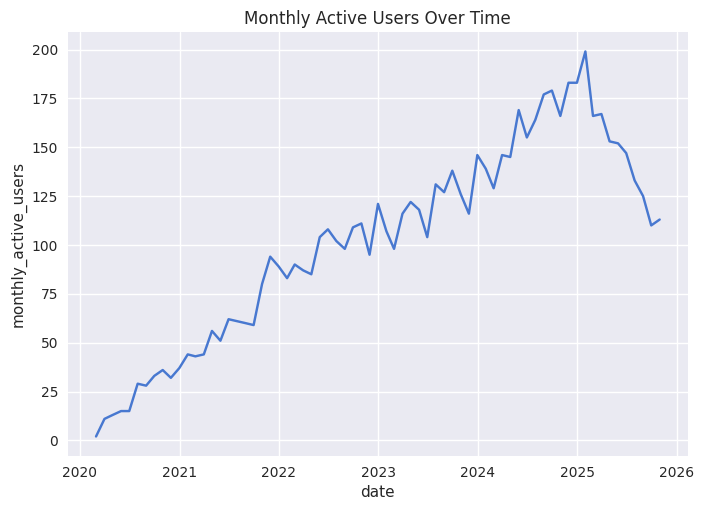

In [61]:
# Monthly Active Users Over Time
monthly_active_users = (
    df.groupby(pd.Grouper(key='date', freq='M'))['user_id']
    .nunique()
    .reset_index(name='monthly_active_users')
)
sns.lineplot(data=monthly_active_users, x='date', y='monthly_active_users')
plt.title('Monthly Active Users Over Time')
plt.show()

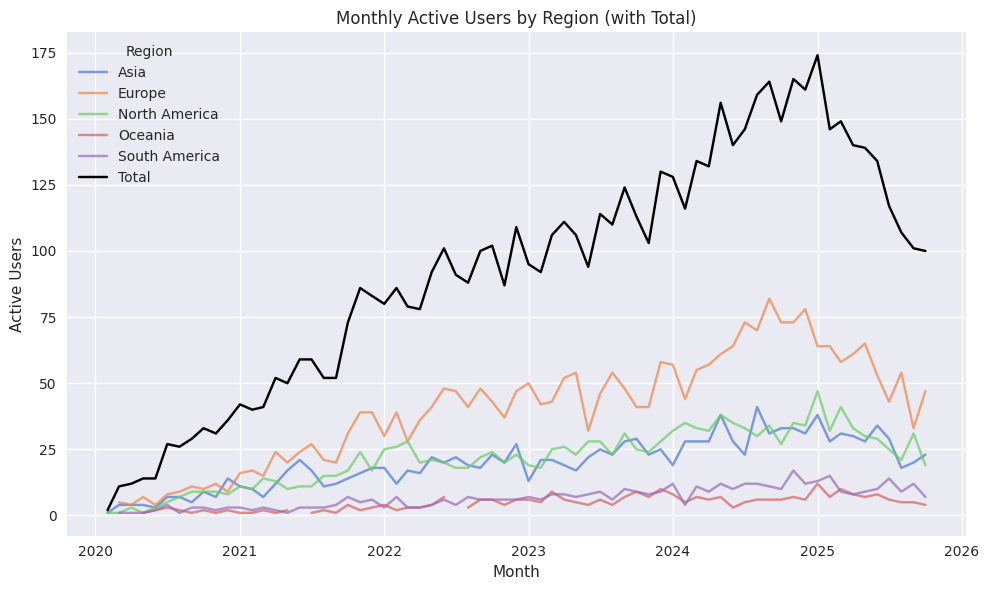

In [62]:
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

# 2. Group by month and region and count distinct users
mau = (
    df
    .groupby(['month', 'region'])['user_id']
    .nunique()
    .reset_index(name='monthly_active_users')
)

mau_pivot = mau.pivot(index='month', columns='region', values='monthly_active_users')

mau_pivot['Total'] = mau_pivot.sum(axis=1)

# Plot
plt.figure(figsize=(10,6))

# Plot regional lines
for region in mau_pivot.columns.drop('Total'):
    plt.plot(mau_pivot.index, mau_pivot[region], label=region, alpha=0.7)

# Plot total line thicker and darker
plt.plot(mau_pivot.index, mau_pivot['Total'], label='Total', color='black')

plt.title('Monthly Active Users by Region (with Total)')
plt.xlabel('Month')
plt.ylabel('Active Users')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

In [63]:
mau_pivot.corr(method='pearson')

region,Asia,Europe,North America,Oceania,South America,Total
region,,,,,,
Asia,1.000000,0.861450,0.870126,0.767969,0.792129,0.936005
Europe,0.861450,1.000000,0.865089,0.728198,0.834570,0.970801
North America,0.870126,0.865089,1.000000,0.772031,0.821127,0.945822
Oceania,0.767969,0.728198,0.772031,1.000000,0.735701,0.813131
South America,0.792129,0.834570,0.821127,0.735701,1.000000,0.885262
Total,0.936005,0.970801,0.945822,0.813131,0.885262,1.000000


#### Average Watch time

        date  avg_watch_time_per_user_per_day_min
0 2020-02-29                            63.000000
1 2020-03-31                            38.363636
2 2020-04-30                            12.692308
3 2020-05-31                            36.933333
4 2020-06-30                            39.200000


/tmp/ipykernel_2190/1951735710.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key='date', freq='M'), 'user_id'])['watch_duration']


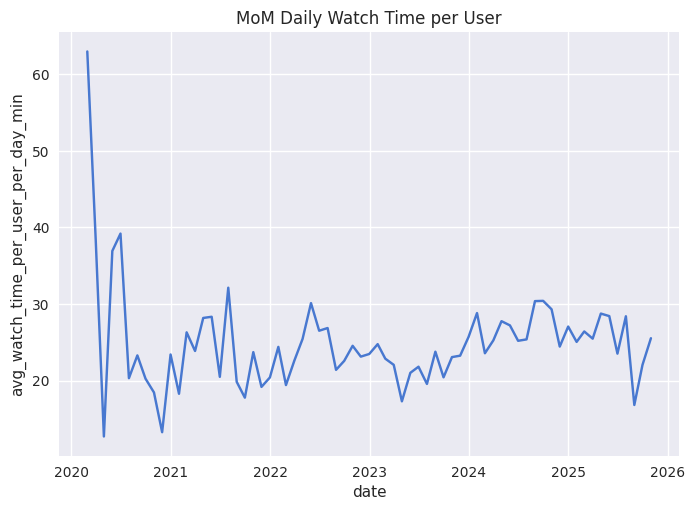

In [64]:
# MoM Average Watch time per User per day
MoM_avg_watch_time_per_user_per_day = (
    df.groupby([pd.Grouper(key='date', freq='M'), 'user_id'])['watch_duration']
    .sum()
    .reset_index()
    .groupby('date')['watch_duration']
    .mean()
    .reset_index(name='avg_watch_time_per_user_per_day_min')
)
print(MoM_avg_watch_time_per_user_per_day.head())
sns.lineplot(data=MoM_avg_watch_time_per_user_per_day, x='date', y='avg_watch_time_per_user_per_day_min')
plt.title('MoM Daily Watch Time per User')
plt.show()

/tmp/ipykernel_2190/661536685.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key='date', freq='M'), 'region', 'user_id'])['watch_duration']


        date         region  avg_watch_time_per_user_per_day_min
0 2020-02-29           Asia                               115.00
1 2020-02-29  North America                                11.00
2 2020-03-31           Asia                                10.25
3 2020-03-31         Europe                                70.40
4 2020-03-31  North America                                28.00


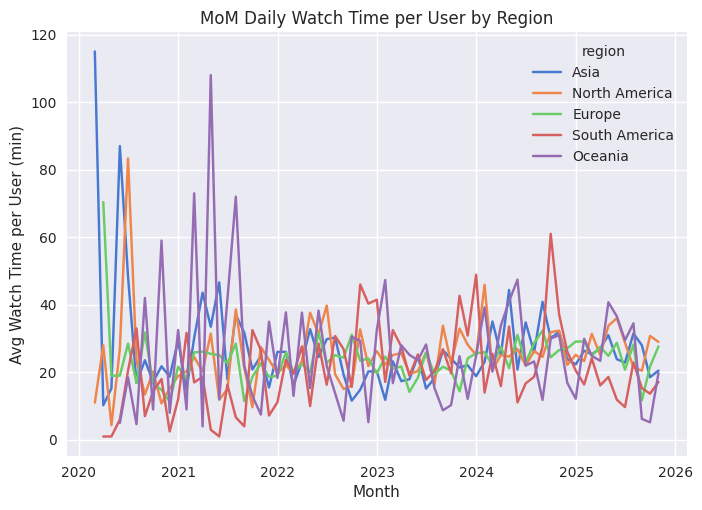

In [65]:
# MoM Average Watch Time per User per Day segmented by Region
MoM_avg_watch_time_per_user_per_day_region = (
    df.groupby([pd.Grouper(key='date', freq='M'), 'region', 'user_id'])['watch_duration']
    .sum()
    .reset_index()
    .groupby(['date', 'region'])['watch_duration']
    .mean()
    .reset_index(name='avg_watch_time_per_user_per_day_min')
)

print(MoM_avg_watch_time_per_user_per_day_region.head())

# Plot segmented by region
sns.lineplot(
    data=MoM_avg_watch_time_per_user_per_day_region,
    x='date',
    y='avg_watch_time_per_user_per_day_min',
    hue='region'
)
plt.title('MoM Daily Watch Time per User by Region')
plt.ylabel('Avg Watch Time per User (min)')
plt.xlabel('Month')
plt.show()


<Axes: xlabel='date'>

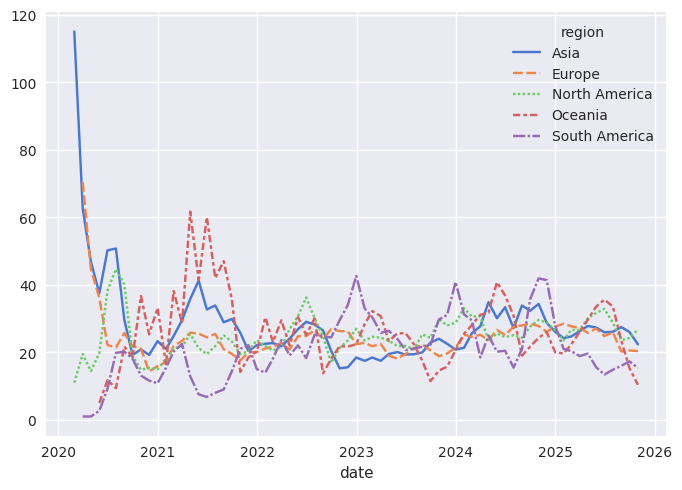

In [66]:
pivot_df = MoM_avg_watch_time_per_user_per_day_region.pivot(
    index='date', columns='region', values='avg_watch_time_per_user_per_day_min'
)
df_smooth = pivot_df.rolling(3, min_periods=1).mean()
sns.lineplot(data=df_smooth)

In [67]:
MoM_avg_watch_time_per_user_per_day_region_pivot = MoM_avg_watch_time_per_user_per_day_region.pivot(
    index = 'date',
    columns='region',
    values='avg_watch_time_per_user_per_day_min'
)

MoM_avg_watch_time_per_user_per_day_region_pivot.corr(method='pearson')

region,Asia,Europe,North America,Oceania,South America
region,,,,,
Asia,1.000000,-0.060816,0.074460,-0.013630,-0.137519
Europe,-0.060816,1.000000,0.206563,0.286848,-0.126007
North America,0.074460,0.206563,1.000000,0.122690,0.107168
Oceania,-0.013630,0.286848,0.122690,1.000000,-0.190989
South America,-0.137519,-0.126007,0.107168,-0.190989,1.000000


#### Average Watch Completion

/tmp/ipykernel_2190/1085783690.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key='date', freq='M'))['watch_completion_pct']


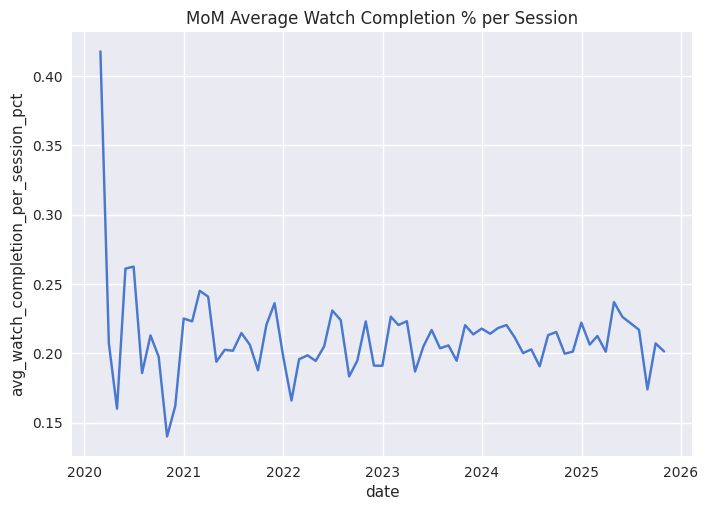

In [68]:
# MoM avg watch completion per session
MoM_avg_watch_completion_per_session = (
    df.groupby(pd.Grouper(key='date', freq='M'))['watch_completion_pct']
    .mean()
    .reset_index(name='avg_watch_completion_per_session_pct')
)
sns.lineplot(data=MoM_avg_watch_completion_per_session, x='date', y='avg_watch_completion_per_session_pct')
plt.title('MoM Average Watch Completion % per Session')
plt.show()

#### Subscriber growth

/tmp/ipykernel_2190/2493977845.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  users.groupby(pd.Grouper(key='signup_date', freq='M'))['user_id']


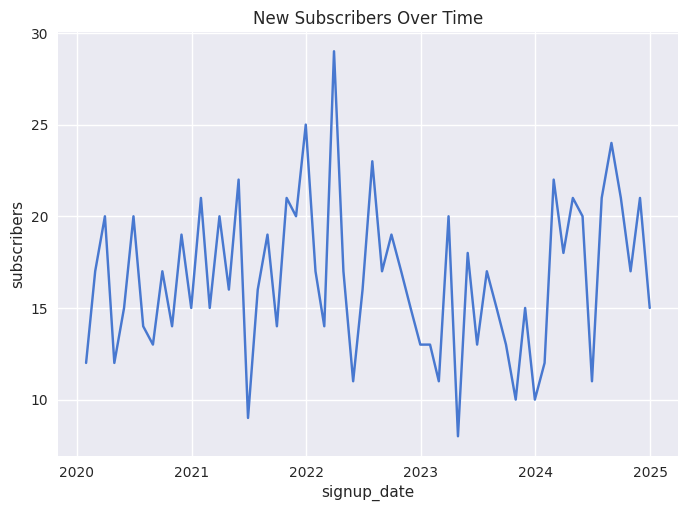

In [69]:
# New Subscribers Over Time
subscribers_over_time_df = (
    users.groupby(pd.Grouper(key='signup_date', freq='M'))['user_id']
    .nunique()
    .reset_index(name='subscribers')
)
sns.lineplot(data=subscribers_over_time_df, x='signup_date', y='subscribers')
plt.title('New Subscribers Over Time')
plt.show()

/tmp/ipykernel_2190/2767257695.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  users[users['cancel_date'].notnull()].groupby(pd.Grouper(key='cancel_date', freq='M'))['user_id']


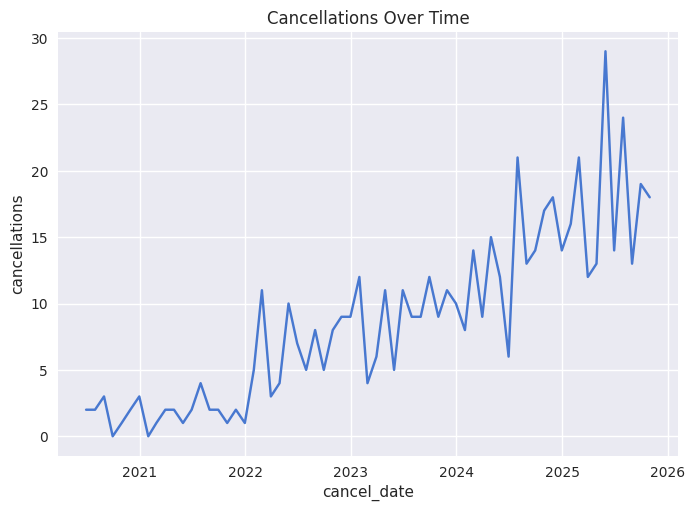

In [70]:
# Cancellations over Time
cancellations_over_time_df = (
    users[users['cancel_date'].notnull()].groupby(pd.Grouper(key='cancel_date', freq='M'))['user_id']
    .nunique()
    .reset_index(name='cancellations')
)
sns.lineplot(data=cancellations_over_time_df, x='cancel_date', y='cancellations')
plt.title('Cancellations Over Time')
plt.show()

/tmp/ipykernel_2190/3424375698.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=users['signup_date'].min(), end=pd.to_datetime('2025-10-31'), freq='M')


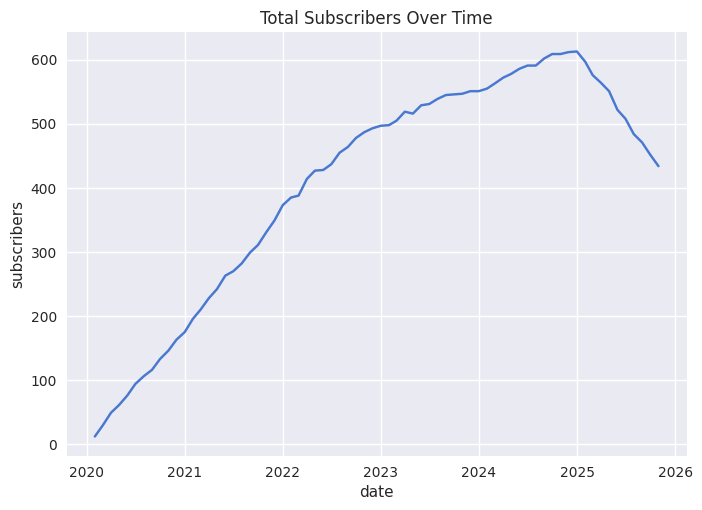

In [71]:
# Subscribers over time
subscribers_over_time = []
current_subscribers = 0
date_range = pd.date_range(start=users['signup_date'].min(), end=pd.to_datetime('2025-10-31'), freq='M')
for date in date_range:     
    new_signups = users[(users['signup_date'] <= date) & ((users['cancel_date'].isna()) | (users['cancel_date'] > date))].shape[0]
    subscribers_over_time.append({'date': date, 'subscribers': new_signups})
subscribers_over_time_df = pd.DataFrame(subscribers_over_time)
sns.lineplot(data=subscribers_over_time_df, x='date', y='subscribers')
plt.title('Total Subscribers Over Time')
plt.show()

/tmp/ipykernel_2190/1167951419.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=users['signup_date'].min(), end=pd.to_datetime('2025-10-31'), freq='M')


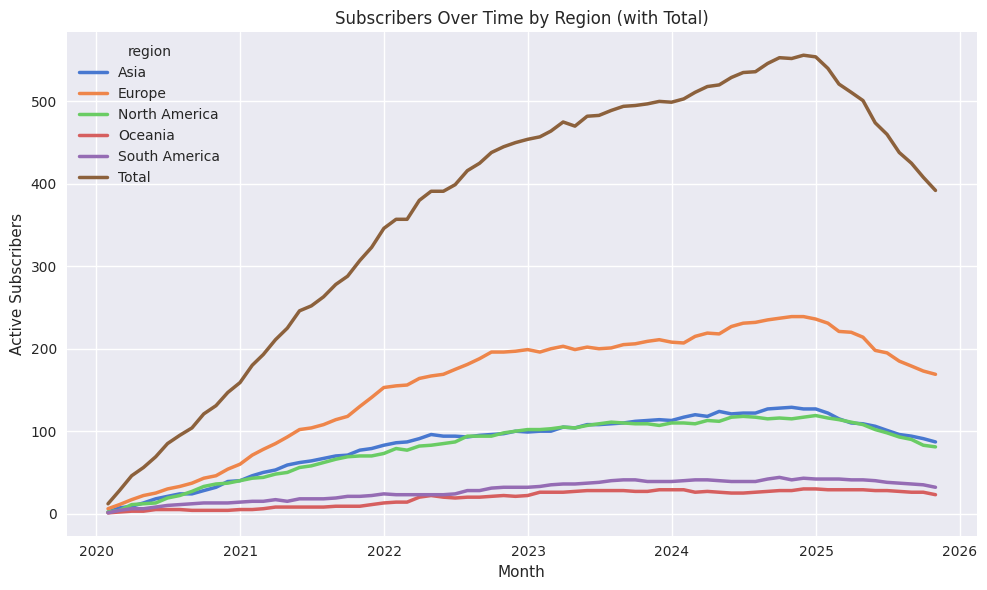

In [72]:
# Total Subscribers Over Time by Region

date_range = pd.date_range(start=users['signup_date'].min(), end=pd.to_datetime('2025-10-31'), freq='M')

records = []

# Loop by region
for region, group in users.groupby('region'):
    for date in date_range:
        active_users = group[(group['signup_date'] <= date) & 
                             ((group['cancel_date'].isna()) | (group['cancel_date'] > date))].shape[0]
        records.append({'date': date, 'region': region, 'subscribers': active_users})

subscribers_by_region = pd.DataFrame(records)

total_over_time = (
    subscribers_by_region.groupby('date')['subscribers'].sum().reset_index()
)
total_over_time['region'] = 'Total'

# Combine with region-level data
subs_over_time_by_region = pd.concat([subscribers_by_region, total_over_time])

plt.figure(figsize=(10,6))
sns.lineplot(data=subs_over_time_by_region, x='date', y='subscribers', hue='region', linewidth=2.5)
plt.title('Subscribers Over Time by Region (with Total)')
plt.xlabel('Month')
plt.ylabel('Active Subscribers')
plt.tight_layout()
plt.show()


In [73]:
subs_over_time_by_region_pivot = subs_over_time_by_region.pivot(
    index='date',
    columns='region',
    values='subscribers'
)

subs_over_time_by_region_pivot.corr(method='pearson')

region,Asia,Europe,North America,Oceania,South America,Total
region,,,,,,
Asia,1.000000,0.993137,0.992299,0.937252,0.959006,0.995213
Europe,0.993137,1.000000,0.993761,0.954294,0.964663,0.998492
North America,0.992299,0.993761,1.000000,0.948751,0.969191,0.996898
Oceania,0.937252,0.954294,0.948751,1.000000,0.970923,0.959907
South America,0.959006,0.964663,0.969191,0.970923,1.000000,0.973980
Total,0.995213,0.998492,0.996898,0.959907,0.973980,1.000000


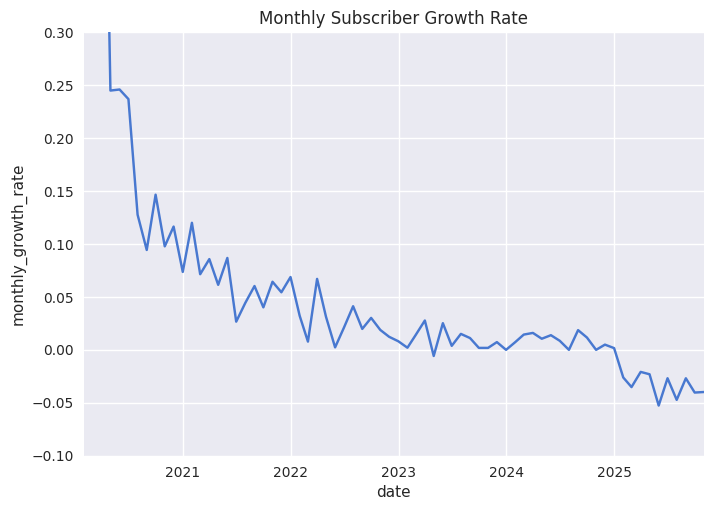

In [74]:
# Monthly Subscriber Growth Rate
subscribers_over_time_df['monthly_growth_rate'] = subscribers_over_time_df['subscribers'].pct_change()
sns.lineplot(data=subscribers_over_time_df, x='date', y='monthly_growth_rate')
plt.title('Monthly Subscriber Growth Rate')
plt.xlim(subscribers_over_time_df['date'].min(), subscribers_over_time_df['date'].max())
plt.ylim(-0.1, 0.3)
plt.show()

#### Activity Rate

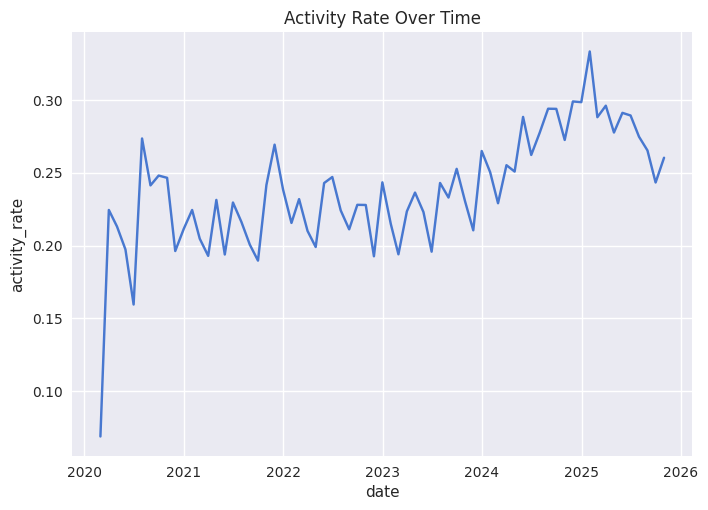

In [75]:
activity_rate = subscribers_over_time_df.merge(monthly_active_users, how='left', on='date')
activity_rate['activity_rate'] = activity_rate['monthly_active_users'] / activity_rate['subscribers']

sns.lineplot(activity_rate, x = 'date', y='activity_rate')
plt.title('Activity Rate Over Time')
plt.tight_layout
plt.show()

#### Monthly Cohort Engagement Retention

/tmp/ipykernel_2190/1024346098.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(key='signup_date', freq='M'), pd.Grouper(key='date', freq='M')])['user_id']
/tmp/ipykernel_2190/1024346098.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  users.groupby(pd.Grouper(key='signup_date', freq='M'))['user_id']


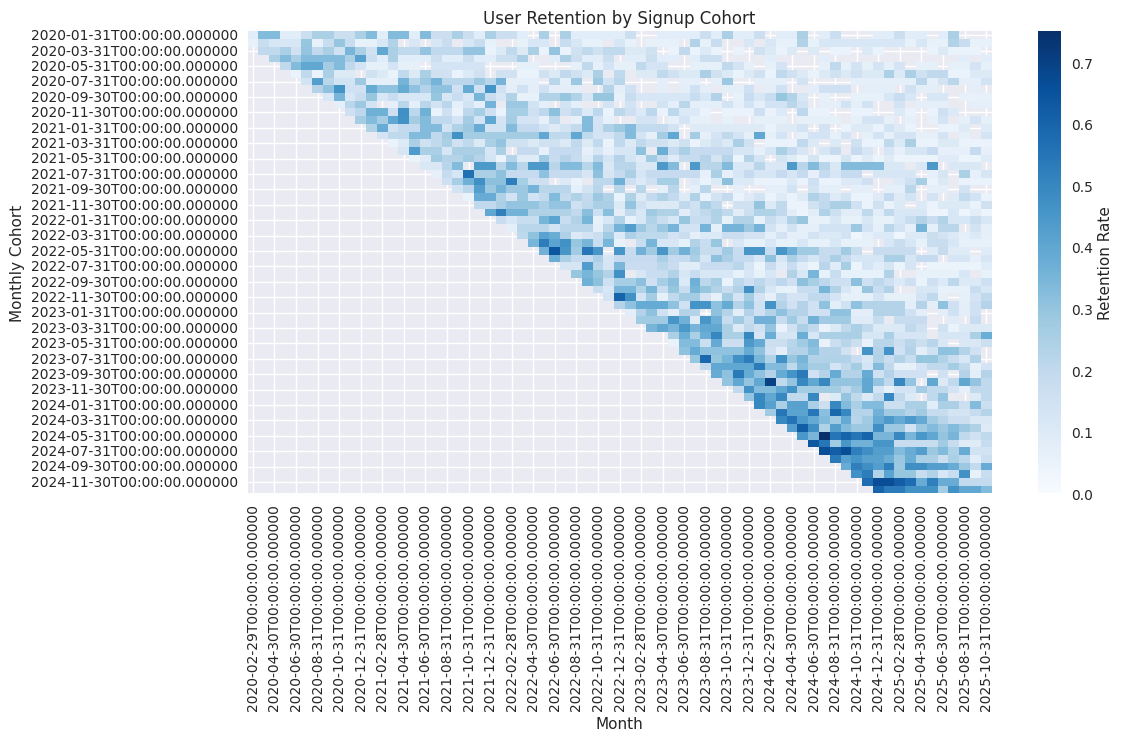

In [76]:
cohort_counts = (
    df
    .groupby([pd.Grouper(key='signup_date', freq='M'), pd.Grouper(key='date', freq='M')])['user_id']
    .nunique()
    .reset_index()
)

# Get cohort size (month 0 count) per signup_date
cohort_sizes = (
    users.groupby(pd.Grouper(key='signup_date', freq='M'))['user_id']
    .nunique()
    .rename('cohort_size')
    .reset_index()
)

# Merge cohort size back into the table
cohort_counts = cohort_counts.merge(
    cohort_sizes,
    on='signup_date',
    how='left'
)

# Compute retention rate
cohort_counts['retention_rate'] = cohort_counts['user_id'] / cohort_counts['cohort_size']

d = cohort_counts['date']
s = cohort_counts['signup_date']
cohort_counts['months_since_signup'] = (d.dt.year - s.dt.year)*12 + (d.dt.month - s.dt.month)

retention_matrix = cohort_counts.pivot(
    index='signup_date',
    columns='date',
    values='retention_rate',
)

plt.figure(figsize=(12,6))
sns.heatmap(retention_matrix, cmap='Blues', annot=False, cbar_kws={'label': 'Retention Rate'}, vmin=0)
plt.title('User Retention by Signup Cohort')
plt.ylabel('Monthly Cohort')
plt.xlabel('Month')
plt.show()

#### Monthly Cohort Churn

/tmp/ipykernel_2190/457040391.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(key='signup_date', freq='M'), pd.Grouper(key='cancel_date', freq='M')])['user_id']
/tmp/ipykernel_2190/457040391.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  users.groupby(pd.Grouper(key = 'signup_date', freq='M'))['user_id']


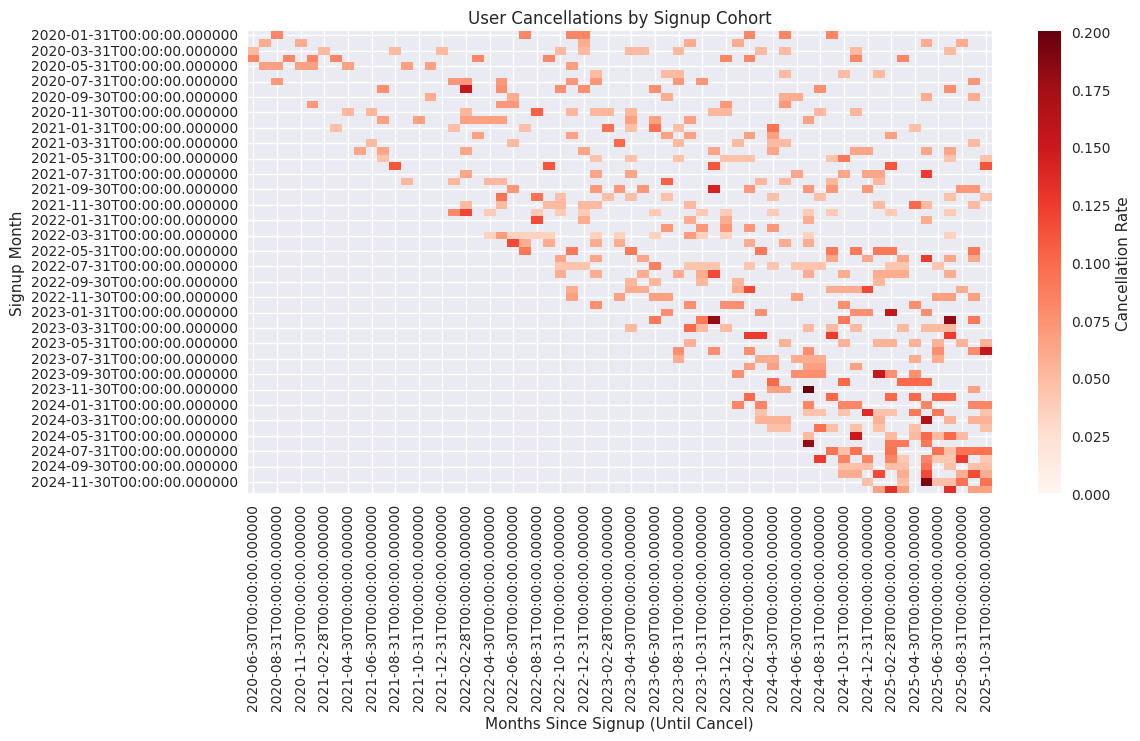

In [77]:
# Churn Heatmap
cancel_counts = (
    users.dropna(subset=['cancel_date'])
    .groupby([pd.Grouper(key='signup_date', freq='M'), pd.Grouper(key='cancel_date', freq='M')])['user_id']
    .nunique()
    .reset_index(name='cancellations')
)

cohort_sizes = (
    users.groupby(pd.Grouper(key = 'signup_date', freq='M'))['user_id']
    .nunique()
    .rename('cohort_size')
    .reset_index()
)

cancel_counts = cancel_counts.merge(cohort_sizes, on='signup_date', how='left')
cancel_counts['churn_rate'] = cancel_counts['cancellations'] / cancel_counts['cohort_size']

churn_matrix = cancel_counts.pivot(
    index='signup_date',
    columns='cancel_date',
    values='churn_rate'
)

plt.figure(figsize=(12,6))
sns.heatmap(
    churn_matrix,
    cmap='Reds',
    annot=False,
    cbar_kws={'label': 'Cancellation Rate'},
    vmin=0
)
plt.title('User Cancellations by Signup Cohort')
plt.xlabel('Months Since Signup (Until Cancel)')
plt.ylabel('Signup Month')
plt.show()

In [78]:
cancel_counts

,signup_date,cancel_date,cancellations,cohort_size,churn_rate
0,2020-01-31,2020-08-31,1,12,0.083333
1,2020-01-31,2022-07-31,1,12,0.083333
2,2020-01-31,2022-11-30,1,12,0.083333
3,2020-01-31,2022-12-31,1,12,0.083333
4,2020-01-31,2024-02-29,1,12,0.083333
...,...,...,...,...,...
490,2024-12-31,2025-02-28,2,15,0.133333
491,2024-12-31,2025-03-31,1,15,0.066667
492,2024-12-31,2025-07-31,2,15,0.133333
493,2024-12-31,2025-09-30,1,15,0.066667


### Content

#### Engagement

In [ ]:
#total_watch_time, #avg_watch_time_per_user, #completion_rate

content_perf = (
    sessions.merge(title, on='title_id')
    .groupby(['title_id', 'content_type', 'genre'])
    .agg(
        viewers=('user_id', 'nunique'),
        total_watch_time=('duration', 'sum'),
        avg_watch_time=('duration', 'mean'),
        sessions_count=('session_id', 'count')
    )
    .reset_index()
)

,title_id,content_type,genre,viewers,total_watch_time,avg_watch_time,sessions_count,watch_time_per_viewer
0,T0001,Movie,Action,60,630.0,10.327869,61,10.500000
1,T0002,Movie,Documentary,53,1490.0,26.607143,56,28.113208
2,T0003,TV Show,Romance,58,675.0,10.887097,62,11.637931
3,T0004,TV Show,Animation,52,308.0,5.923077,52,5.923077
4,T0005,Movie,Comedy,45,940.0,19.183673,49,20.888889
...,...,...,...,...,...,...,...,...
182,T0195,Movie,Romance,38,687.0,16.756098,41,18.078947
183,T0196,Movie,Sci-Fi,52,1939.0,35.907407,54,37.288462
184,T0198,TV Show,Fantasy,46,363.0,7.891304,46,7.891304
185,T0199,Movie,Animation,51,1585.0,31.078431,51,31.078431


<Axes: xlabel='Count', ylabel='viewers'>

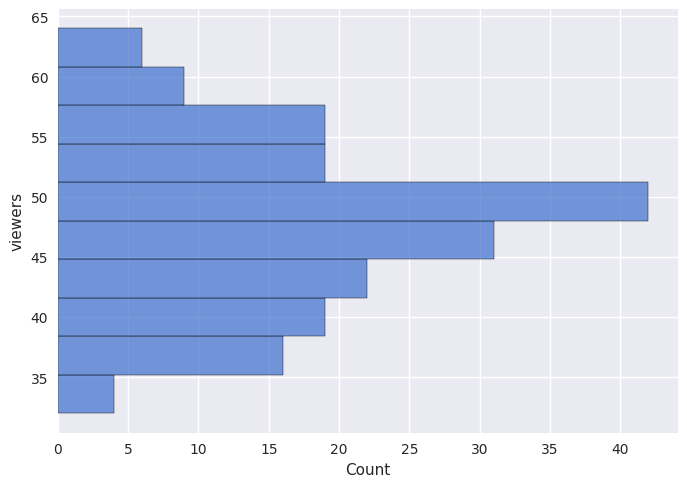

In [89]:
sns.histplot(content_perf, y='viewers')

<Axes: xlabel='Count', ylabel='total_watch_time'>

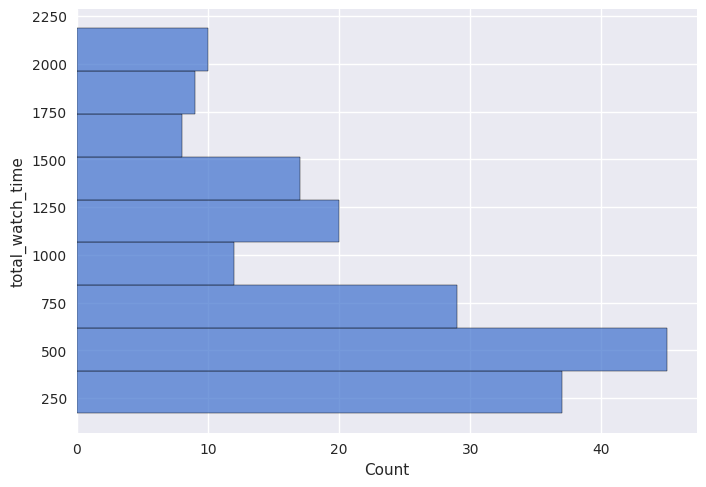

In [90]:
sns.histplot(content_perf, y='total_watch_time')

<Axes: xlabel='Count', ylabel='avg_watch_time'>

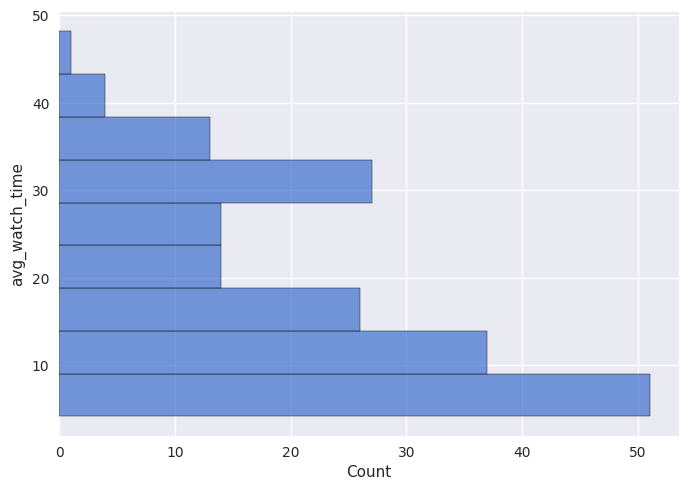

In [91]:
sns.histplot(content_perf, y='avg_watch_time')

## Deep Dive

### What caused the dip in 2025?

### What behavior differences can we see from churned vs. retained users?